This notebook contains 

- [x] How noise changes somite size distribution  
- [x] Does coupling have any effect on the somite size distribution with noise added
- [x] Average Inter peak distance as noise is added
- [x] Average Inter peak distance downstream as noise is added

* Can somites be rescued by changing some other parameter in the simulation as the noise is increased 
* Effect of different distribution of noise added on the somite size distribution
* Better ways of characterizing signal quality for finite signals of the kind i have in the simulation 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, mode
from math import sqrt
import time 
import numpy as np
import matplotlib.animation as animation
%matplotlib notebook
from scipy import signal
import math
import scipy.optimize as optimize
import scipy.io as sio
import scipy.signal as signal
import itertools
from scipy.fftpack import fft, ifft
plt.style.use('seaborn')
import pickle
from scipy import stats
from zebra_chord import *
from collect_statistics import *
from visualization import *
from mpl_toolkits.mplot3d import Axes3D
import scipy
import copy

In [2]:
dic = return_default_dic()
dic["v_0"] = .25
dic["dt"] = 0.5
dic["n_t"]  = 200
dic["n_c"] = 50
dic["dx"] = 0.75
dic["delay"] = 11
dic["tau_d"] = round(dic["delay"]/dic["dt"])
dic["u_0"] = .5
dic["c"] = 20
dic["tau_w"] = 1.
dic["gamma1"] = 21
dic["tau_c"] = 0
dic["tau_2"] = 20
dic["beta"] = 0.1
dic["n"] = 4
dic["m"] = 5
dic["K_u"] = 0.3
dic["loc"] = 40
dic["sigma_1"] = 0.026 ## std deviation of the white noise added
dic["sigma_2"] = 0.026 ## std deviation of the white noise added

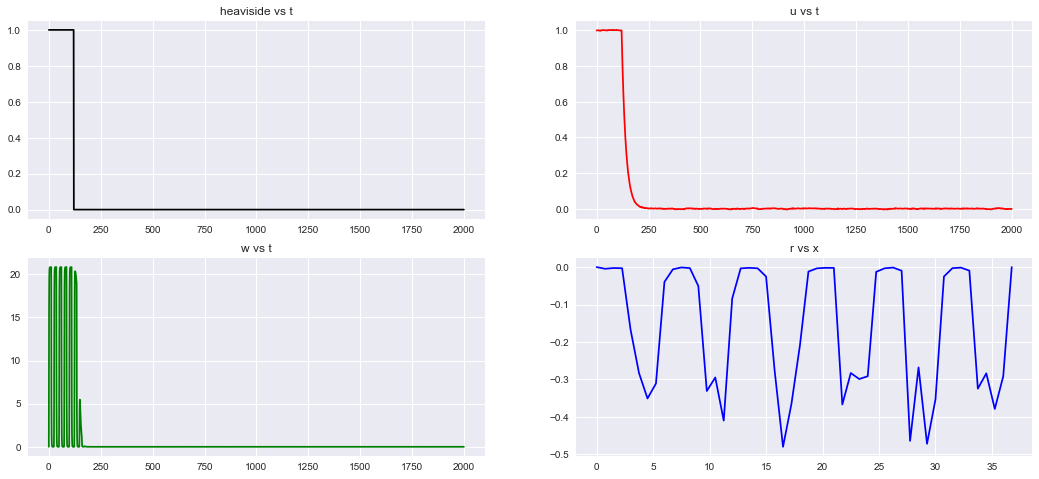

In [3]:
u, w, r, h, t, x = run_sim_(dic, coupling= False, noise = True,plot = True, plot_r = False, plot_mollifier=False)


In [4]:
loc  = 30
clip_signal = 250
by = 3
beta = np.linspace(0, 1, 500)
noise  = np.linspace(0, 1, 500)


In [5]:
data = pickle.load(open("data_uncoupled_noisy.pkl", "rb"))

In [6]:
u_list, w_list, r_list = data
len(u_list), u_list[0].shape

(500, (50, 4000))

In [7]:
def compute_signif_tc(data): 
    slevel = 0.95  # Significance level
    std = data.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    var = (data - data.mean()) / std       # Calculating anomaly and normalizing

    dj = 0.5                            # Four sub-octaves per octaves
    s0 = -1 #2 * dt                      # Starting scale, here 6 months
    J = -1 # 7 / dj                      # Seven powers of two with dj sub-octaves
    dt = 0.25
    N = data.size

    alpha = np.corrcoef(var[0:-1], var[1:])[0,1]; 

    mother = wavelet.Morlet(6.)          # Morlet mother wavelet with wavenumber=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.

    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(data, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)
    power = (abs(wave)) ** 2             # Normalized wavelet power spectrum
    fft_power = std2 * abs(fft) ** 2     # FFT power spectrum
    period = 1. / freqs

    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                            significance_level=slevel, wavelet=mother)
    sig95 = (signif * np.ones((N, 1))).transpose()
    sig95 = power / sig95                # Where ratio > 1, power is significant
    return sig95

In [8]:
data = w_list[60][30]

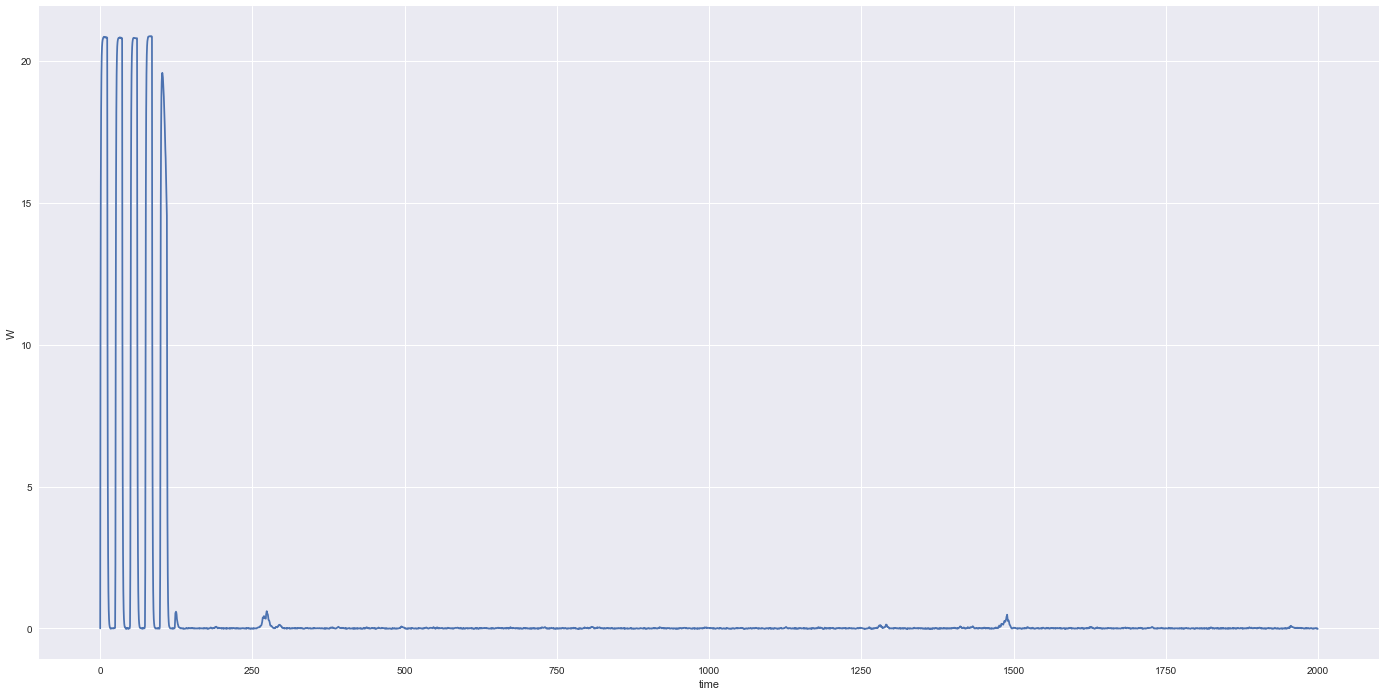

In [9]:
plt.figure(figsize=(24, 12))
plt.ylabel("W")
plt.xlabel("time")
plt.plot(t, data)

In [15]:
    
def plot_scaleogram(sig, wavelet="morl", width_max = 201):
    """
    plots scaleogram of using cwt
    cwt : takes a wavelet a compact wave of finite size 
    and computes convolution with signal at varying scales of the wavelet by translating
    it over the signal gives the output as (scale, n_data)
    
    interpretation : dark bands show power of signal darker bands = more power 
    
    advantages : better than using stft as provides information about both freq and time
               : doesnt assume signal is infinite 
               : has significance tests so we can distinguish whether scaleogram is because of signal or just random noise 
               : use instead of quality factor which is for infinite signals 
    """
    coef, freqs=pywt.cwt(sig,np.arange(1,201),wavelet)
    plt.xlabel("Time")
    plt.ylabel("Scales")
    plt.imshow(coef, cmap='PRGn', aspect='auto',
           vmax=abs(coef).max(), vmin=-abs(coef).max())
    plt.show()

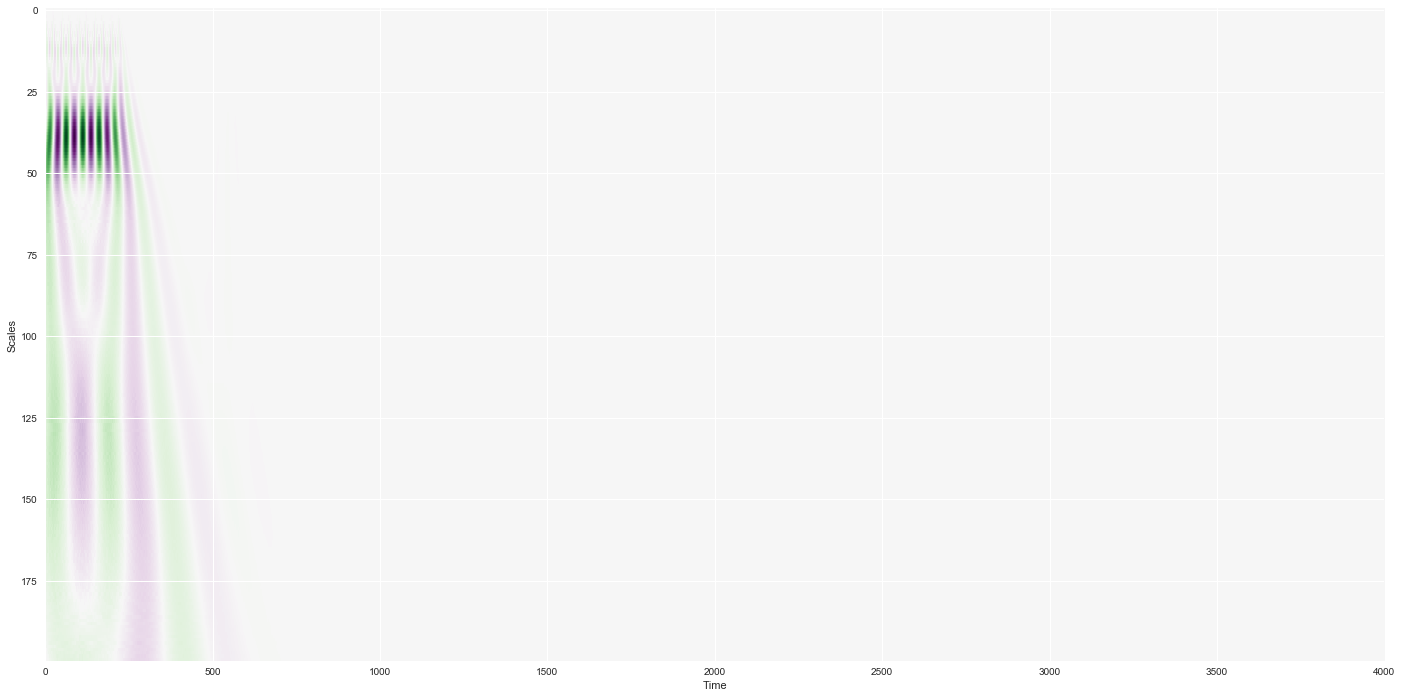

In [16]:
plt.figure(figsize=(24, 12))
plot_scaleogram(data)



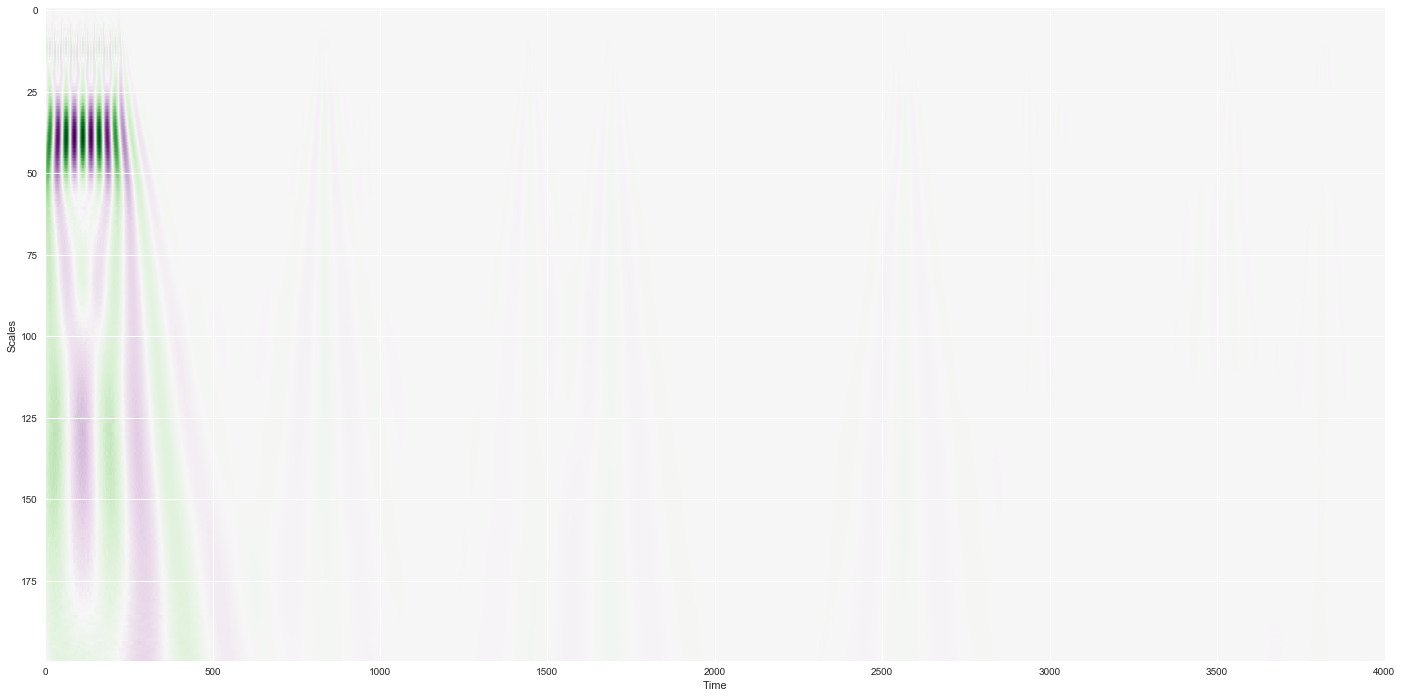

In [18]:
plt.figure(figsize=(24, 12))
plot_scaleogram(w_list[80][30])


In [117]:
def get_interpeak_distance(sig, distance):
    peaks, _ = scipy.signal.find_peaks(sig)
    return np.diff(distance[peaks])

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def get_flatline(sig):
    """
    finds the flatline in the signal by finding all stretches of zeros and then gettting the index 
    of the longest stretch 
    """
    diff = np.diff(copy.deepcopy(sig))
    sub_threshold_indices = diff < 1e-5
    diff[sub_threshold_indices] = 0
    zero_ranges = zero_runs(diff)
    len_zeros = [(z[1]-z[0]) for z in zero_ranges]
    ind = zero_ranges[np.argmax(len_zeros)][0]
    return ind

In [131]:
avg_d = []
for wi in w_list:
    sig = wi[loc]
    ind = get_before_flatline(sig)
    dist = get_interpeak_distance( sig[:ind],t[:ind])
    avg_dist = np.average(dist[:-1])
    avg_d.append(avg_dist)

/anaconda3/envs/rem/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/anaconda3/envs/rem/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


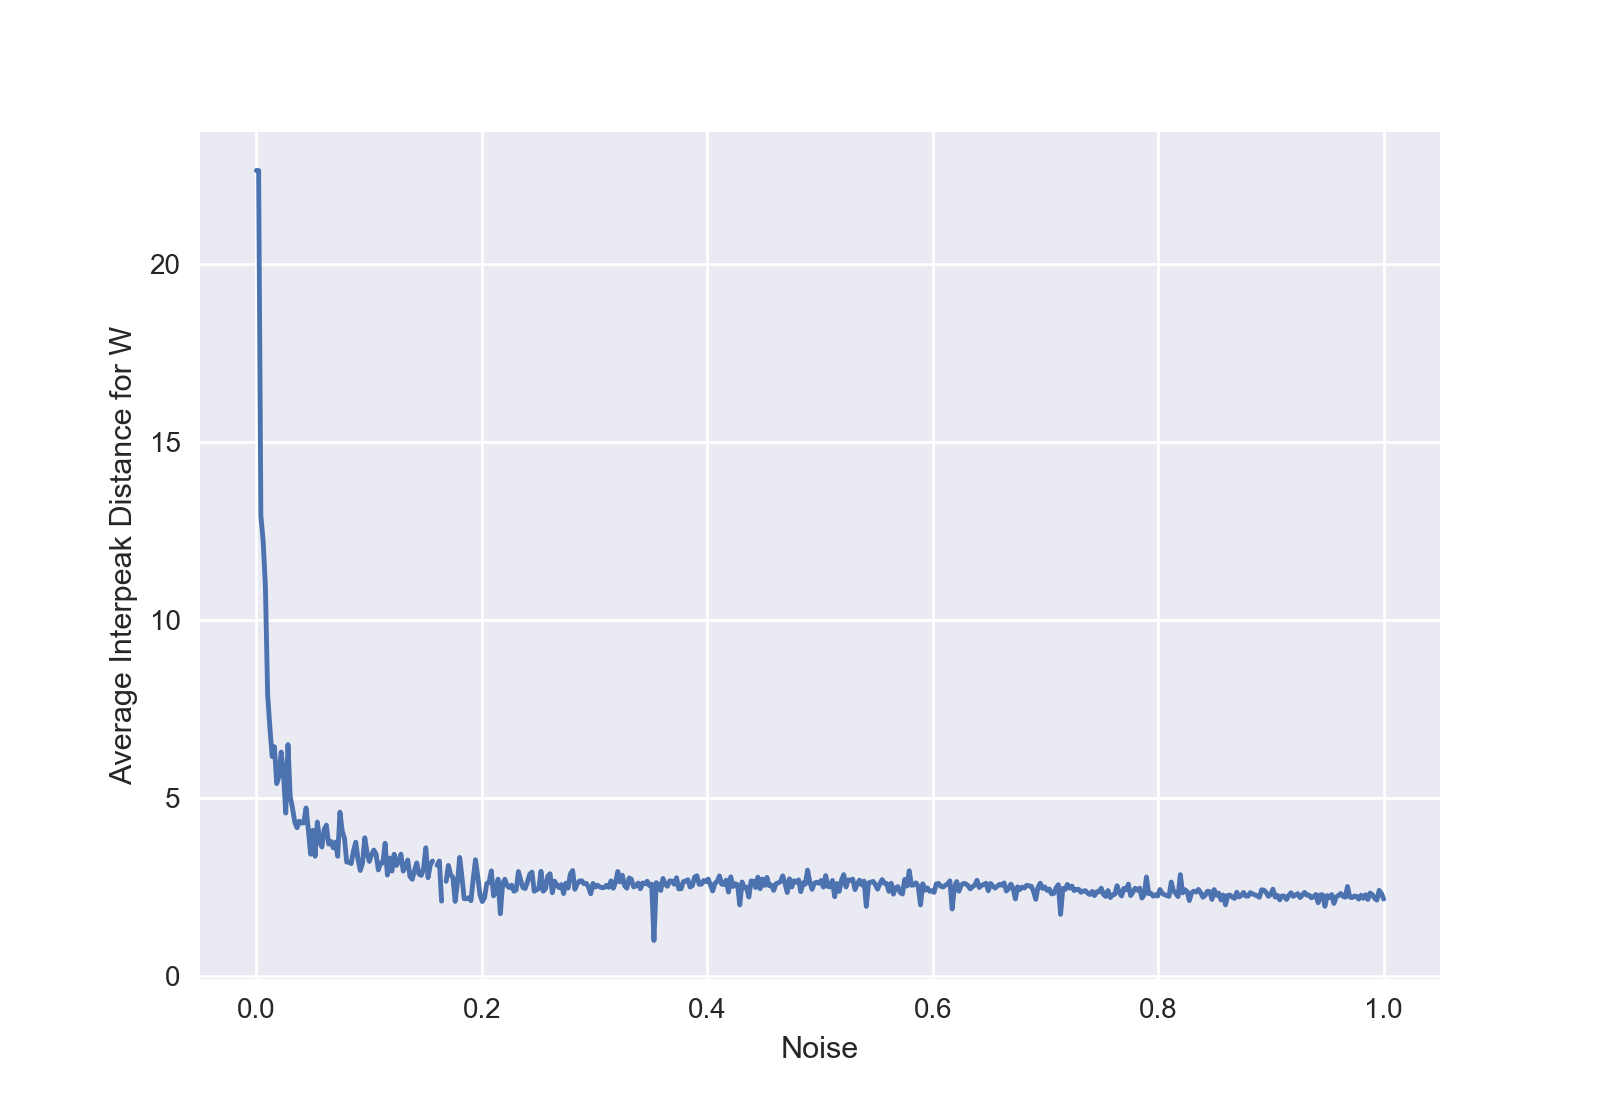

In [136]:
plt.xlabel("Noise")
plt.ylabel("Average Interpeak Distance for W")
plt.plot(noise,avg_d)

<IPython.core.display.Javascript object>


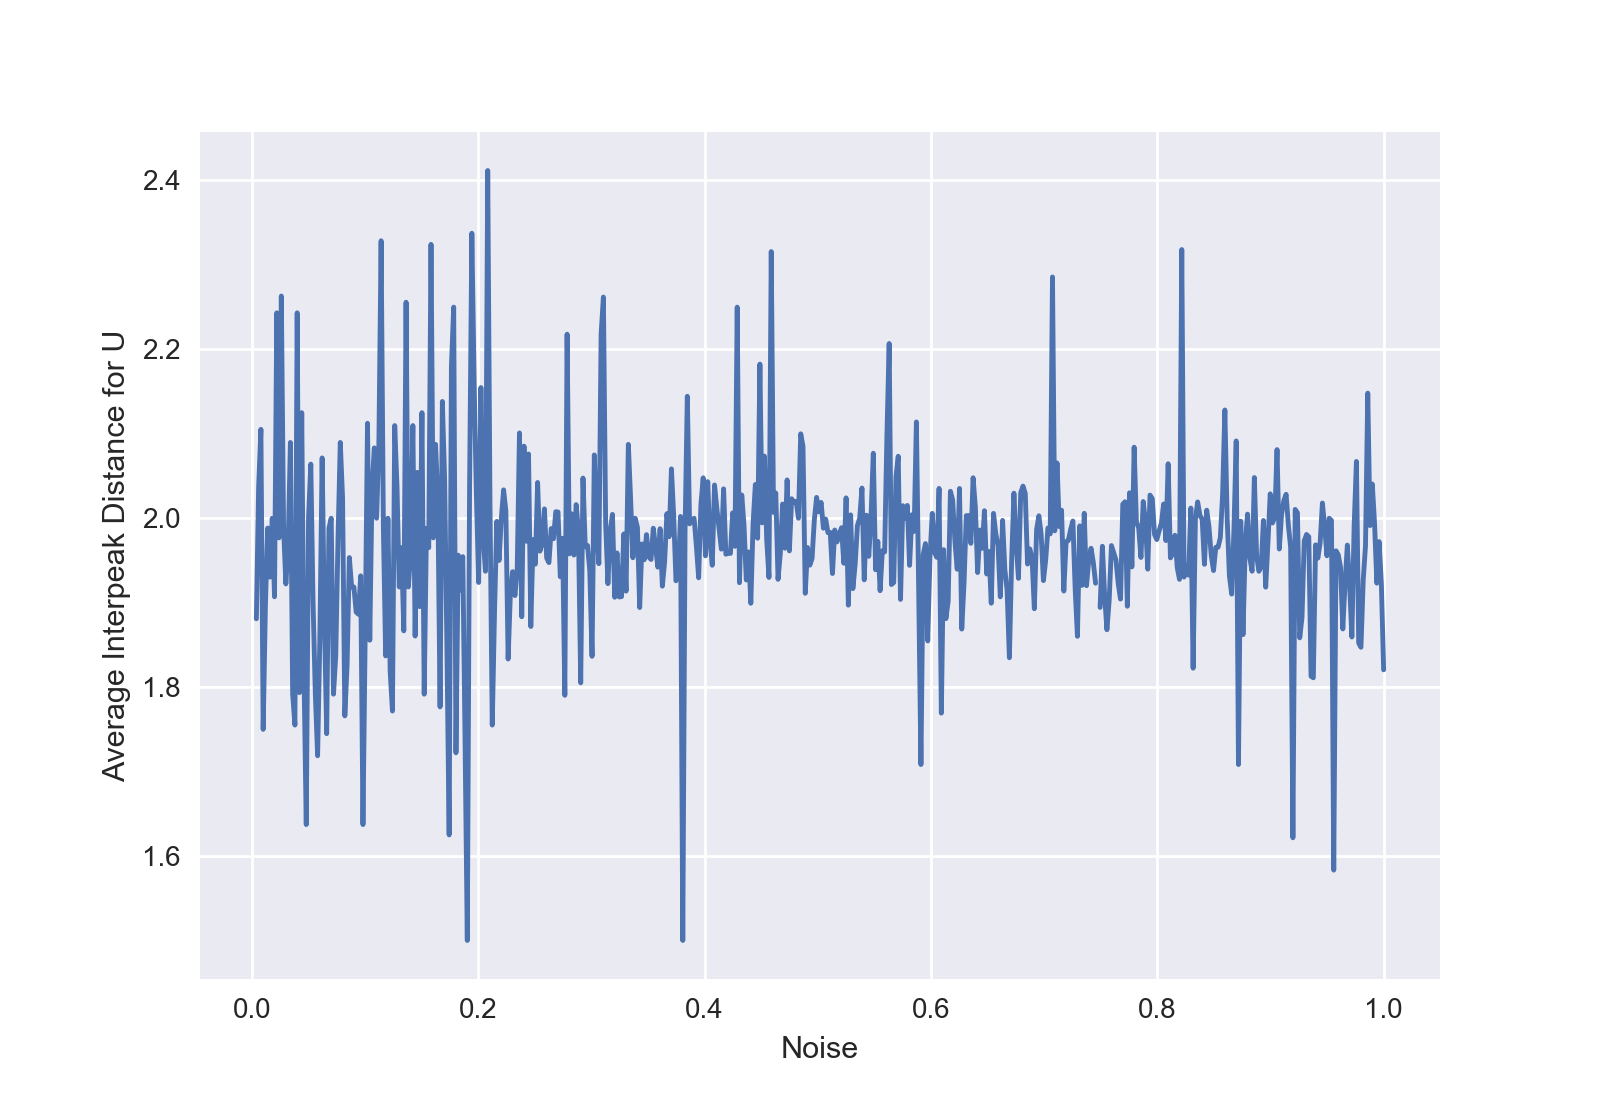

In [137]:
avg_d = []
for wi in u_list:
    sig = wi[loc]
    ind = get_before_flatline(sig)
    dist = get_interpeak_distance( sig[:ind],t[:ind])
    avg_dist = np.average(dist[:-1])
    avg_d.append(avg_dist)
plt.xlabel("Noise")
plt.ylabel("Average Interpeak Distance for U")
plt.plot(noise,avg_d)

<IPython.core.display.Javascript object>


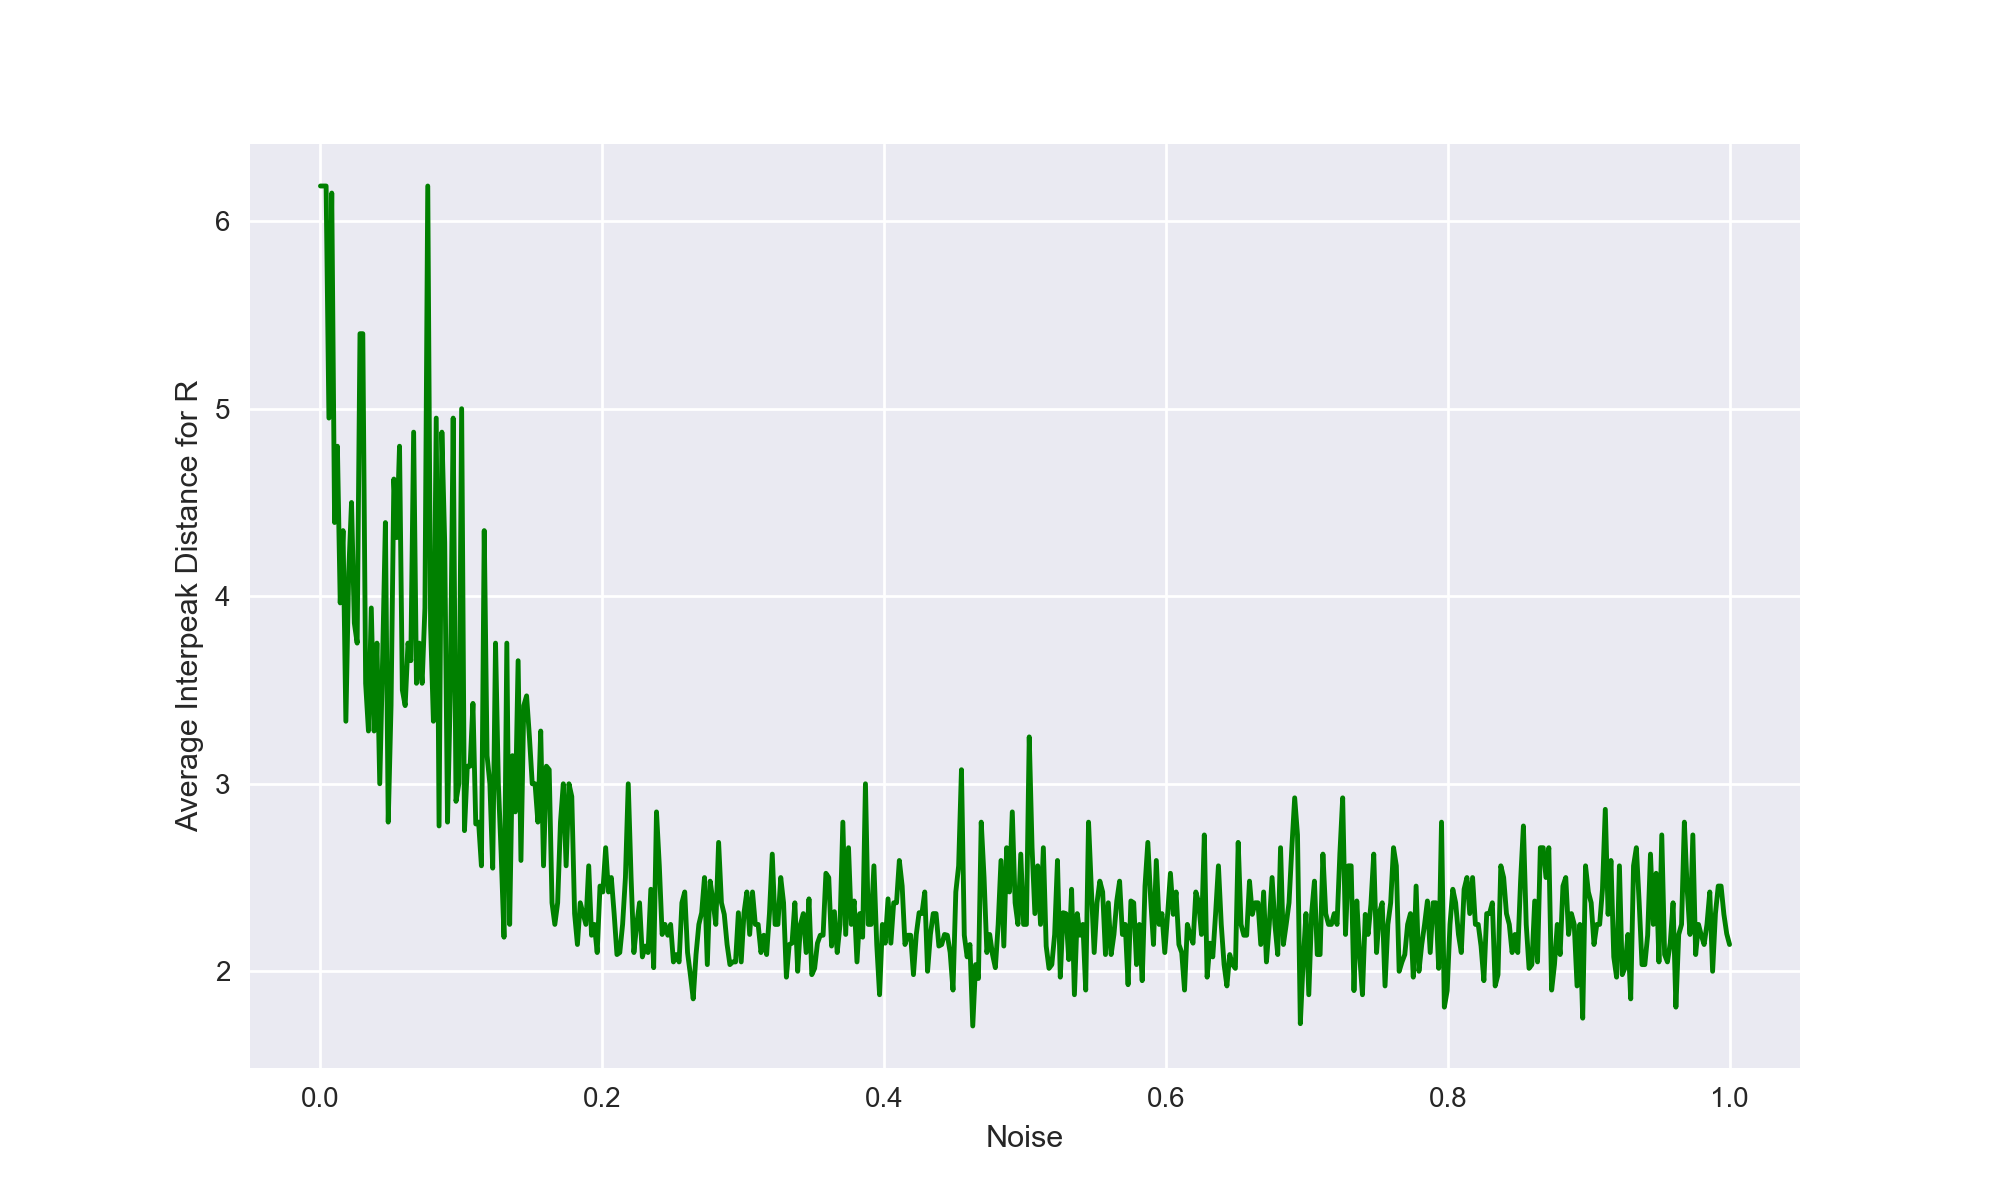

In [163]:
avg_d = []
for wi in r_list:
    sig = wi
    dist = get_interpeak_distance( sig,x)
    avg_dist = np.average(dist[:-1])

    avg_d.append(avg_dist)
plt.figure(figsize=(10,6))
plt.xlabel("Noise")
plt.ylabel("Average Interpeak Distance for R")
plt.plot(noise,avg_d, c = "g")

#### Average Interpeak Distance for w oscillations as we go downstream with noise 

In [175]:
w_no_noise = w_list[0]
w_m_noise = w_list[250]
w_s_noise = w_list[50]

w_h_noise = w_list[-1]
cells = np.linspace(0, 50, 50)
av_d = []

for n in range(100):
    sig = w_list[n*5]
    avg_d = []
    for c in range(50):

        ind = get_before_flatline(sig[c])
        dist = get_interpeak_distance( sig[c][:ind],t[:ind])
        avg_dist = np.average(dist[:-1])
        avg_d.append(avg_dist)

    av_d.append(avg_d)



<IPython.core.display.Javascript object>


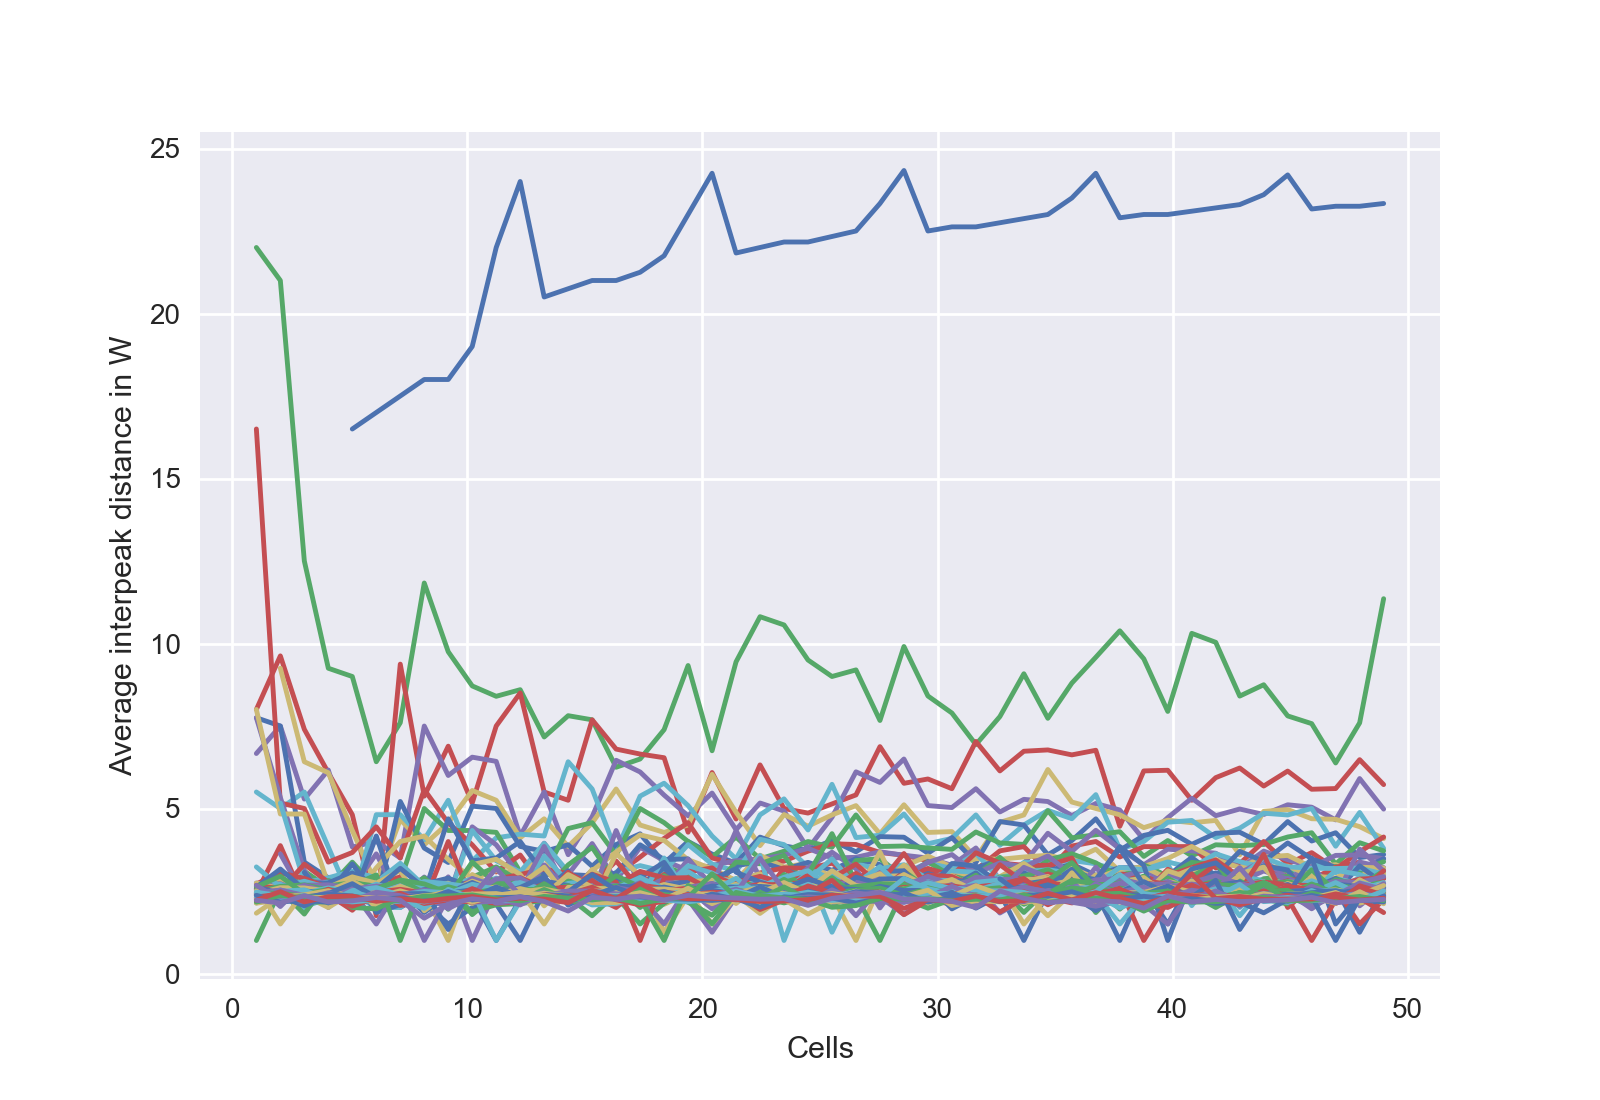

In [179]:
plt.xlabel("Cells")
plt.ylabel("Average interpeak distance in W")
for i in range(100):
    plt.plot(cells, av_d[i])
